In [1]:
using PyPlot, Interact

addprocs(12);

@everywhere push!(LOAD_PATH, "../src/")
@everywhere using HDStat, LTI

@everywhere function specErr(s1, s2)
    n1 = length(s1); n2 = length(s2);
    assert(n1 <= n2)
    err = 0.0;
    for k in 1:n1
        d, idx = findmin(abs(s1[k] - s2).^2)
        err = max(err, d / abs(s1[k]))
    end
    return err
end

INFO: Loading help data...


In [2]:
@everywhere type DynModel
    ϕs::Number
    ϕn::Number
    σs::Number
    Ws::Array{Float64, 2}
    Us::Array{Float64, 2}
    Un::Array{Float64, 2}
    S::Array{Float64, 2}
    N::Integer
    K::Integer
    M::Integer
    T::Integer
end

@everywhere type NLDynModel
    base::DynModel
    scale::Number
end

@everywhere function DynModel(N, K, M, T, ϕs, ϕn, σs)
    Ws = genDynRot(K, K, 0, ϕs, 0, pi / 2)[1]
    U = qr(randn(N, N))[1]
    Us = U[:, 1:K]
    Un = U[:, K + 1:end]
    S = eye(N)[randperm(N)[1:M], :]
    
    DynModel(ϕs, ϕn, σs, Ws, Us, Un, S, N, K, M, T)
end

@everywhere function sample(m::DynModel)
    C = eye(m.K);
    Q = eye(m.K) * m.σs^2;
    R = eye(m.K) * 0;
    p = eye(m.K) / (1 - m.ϕs^2) * m.σs^2
    Xs = runLTI(m.Ws, C, Q, R, m.T; P=p)[1]
    m.S * (m.Us * Xs + m.Un * rand(ARMPModel(m.N - m.K, m.T, m.ϕn, 1)))
end

@everywhere function sample(m::NLDynModel)
    C = eye(m.base.N)
    Q = m.base.Us * eye(m.base.K) * m.base.Us' * m.base.σs^2 + m.base.Un * m.base.Un'
    R = eye(m.base.N) * 0;
    p = m.base.Us * (eye(m.base.K) ./ (1 - m.base.ϕs^2) * m.base.σs^2) * m.base.Us'
    p += m.base.Un * (eye(m.base.N - m.base.K) / (1 - m.base.ϕn^2)) * m.base.Un'
    W = m.base.Us * m.base.Ws * m.base.Us' + m.base.Un * diagm(ones(m.base.N - m.base.K) * m.base.ϕn) * m.base.Un'
    Xs = runTanh(W, C, Q, R, m.scale, m.base.T; P=p)[1]
    m.base.S * Xs
end

@everywhere function fullSample(m::DynModel)
    C = eye(m.K)
    Q = eye(m.K) * m.σs^2
    R = eye(m.K) * 0
    p = eye(m.K) / sqrt(1 - m.ϕs^2) * m.σs
    Xs = runLTI(m.Ws, C, Q, R, m.T; P=p)[1]
    Xf = m.Us * Xs + m.Un * rand(ARMPModel(m.N - m.K, m.T, m.ϕn, 1))
    X = m.S * Xf
    return {:Xs => Xs, :Xf => Xf, :X => X}
end

# @everywhere function ssid(model::DynModel)
#     X = sample(model)
#     What = hoKalman(X, 3, model.K)[1]
#     return specErr(eig(What)[1], eig(model.sigW)[1])
# end

# @everywhere function ss_overlap(m::DynModel)
#     X = sample(m)
#     U, S, _ = svd(X)
# #     K = sum(S .> sv_outfloor(ARMPModel(m.M, m.T, m.noise.phi, m.noise.sigma)))
# #     if K == 0; return 0; end;
#     U = U[:, 1:m.K]
#     mU = qr(m.S * m.U)[1]
#     return sum(svd(mU' * U)[2]) / size(mU, 2)
# end

# @everywhere function trial(m::DynModel)
#     X = sample(m)
#     U, S, _ = svd(X)
#     Kp = sum(S .> sv_outfloor(ARMPModel(m.M, m.T, m.noise.phi, m.noise.sigma)))
#     U = U[:, 1:m.K]
#     mU = qr(m.S * m.U)[1]
#     What = hoKalman(X, 3, m.K)[1]
#     return Kp, sum(svd(mU' * U)[2]) / size(mU, 2), specErr(eig(What)[1], eig(m.sigW)[1])
# end

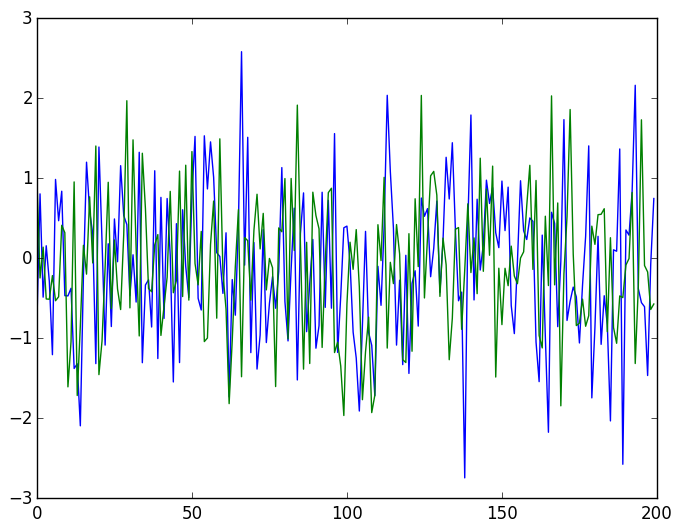

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5071978eb8>

In [7]:
m = NLDynModel(DynModel(100, 2, 20, 200, 0.95, 0.1, 0.05), 0.1)
xbase = sample(m.base)
x = sample(m)

plot(xbase[1, :]')
plot(x[1, :]')

In [40]:
@everywhere function trial(m::DynModel)
    rst = fullSample(m)
    X = rst[:X]
    Xs = m.S * m.Us * rst[:Xs]
    What = hoKalman(sample(m), 3, m.K)[1]
    SV = sqrt(eigs(X * X'; nev=m.K)[1])
    SVs = sqrt(eigs(Xs * Xs'; nev=m.K)[1])
    return specErr(eig(What)[1], eig(m.Ws)[1]), SV[end], SVs[end]
end

@everywhere K, N, ϕs, ϕn = 4, 2000, 0.9, 0.1
@everywhere 𝛕s, 𝛕n = -1 / log(ϕs), -1 / log(ϕn)
@everywhere σss = linspace(0.01, 0.08, 11)
@everywhere M = 250
# @everywhere Ts = map(int, linspace(50, 500 * 𝛕s, 40))
@everywhere T = 250 * 𝛕s

rst = [@spawn trial(DynModel(N, K, M, int(T), ϕs, ϕn, σs * sqrt(N / K))) for σs in σss, k in 1:20]
rst = map(fetch, rst);

err = map(x -> x[1], rst);
evk = map(x -> x[2], rst);
evks = map(x -> x[3], rst);

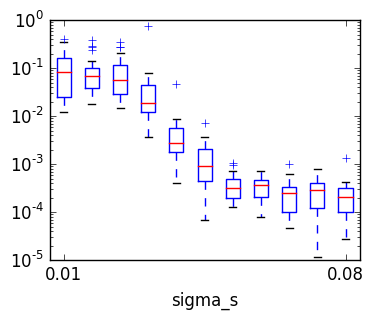

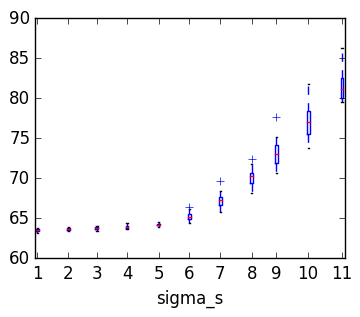

In [44]:
figure(figsize=(4, 3))
boxplot(err')
# plot(err[:, 1])
yscale("log")
xticks([1, length(σss)], [minimum(σss), maximum(σss)])
xlabel("sigma_s")
savefig("../figures/ssid.err.sigma.s.eps")

model = ARMPModel(int(M), int(T), ϕn, 1.0)

figure(figsize=(4, 3))
boxplot(evk', positions=mean(evks, 2))
# plot(mean(evks, 2), mean(evk, 2))
# axhline(y=sv_outfloor(model))
# axvline(x=sv_infloor(model) * (N - K) / N, color="b")
# axvline(x=sqrt(ev_infloor(ARMPCorrModel(model))) * (N - K) / N, color="r")
# xticks([1, length(σss)], [minimum(σss), maximum(σss)])
xlabel("sigma_s")
savefig("../figures/k.eig.sigma.s.eps")
# plot(evks[:, 1])
# yscale("log")

In [45]:
@everywhere K, N, ϕs, ϕn = 4, 2000, 0.9, 0.1
@everywhere 𝛕s, 𝛕n = -1 / log(ϕs), -1 / log(ϕn)
@everywhere σs = 0.05 * sqrt(N / K)
@everywhere Ts = map(int, linspace(50 * 𝛕s, 500 * 𝛕s, 40))
@everywhere Ms = Ts / 𝛕s
# @everywhere T = 250 * 𝛕s

@everywhere function inferK(m::DynModel; X = None)
    if X == None; X = sample(m); end
    model = ARMPModel(m.M, m.T, m.ϕn, 1.0)
    S = svd(X)[2]
    return sum(S .> sv_outfloor(model))
end

rst = [@spawn inferK(DynModel(N, K, int(M), int(T), ϕs, ϕn, σs)) for M in Ms, T in Ts]
dims = map(fetch, rst);

In [48]:
@everywhere function inferKTheory(model::DynModel)
    m, k = model.M / model.N, model.K / model.N
    sig_pow = ev_lb(ARMPModel(model.K, model.T, model.ϕs, model.σs))
    sig_pow *= 1 * (sqrt(m * (1 - k)) - sqrt(k * (1 - m)))^2
#     noise_pow = ev_infloor(ARMPCorrModel(ARMPModel(model.M, model.T, model.ϕn, 1.0)))
    noise_pow = ev_infloor(ARMPModel(model.M, model.T, model.ϕn, 1.0))
    return sig_pow > noise_pow
end

rst = [@spawn inferKTheory(DynModel(N, K, int(M), int(T), ϕs, ϕn, σs)) for M in Ms, T in Ts]
theory = map(fetch, rst);

In [50]:
@everywhere function recErr(m::DynModel)
    What = hoKalman(sample(m), 3, m.K)[1]
    return specErr(eig(What)[1], eig(m.Ws)[1])
end

rst = [@spawn recErr(DynModel(N, K, int(M), int(T), ϕs, ϕn, σs)) for M in Ms, T in Ts]
err = map(fetch, rst);

40x40 Array{Float64,2}:
 0.341798    0.0162748   0.156763    0.198156    …  0.0973597    0.029846   
 0.00438828  0.0837323   0.0761361   0.198685       0.0162715    0.0125629  
 0.0286657   0.0622357   0.0757075   0.0635291      0.0128822    0.00921051 
 0.0212437   0.0239612   0.104383    0.0628681      0.00598365   0.0115949  
 0.144218    0.0280449   0.0136025   0.0131116      0.00272662   0.00251597 
 0.0725893   0.0282522   0.285049    0.0227554   …  0.00408519   0.00418492 
 0.00696499  0.0130738   0.0257377   0.243449       0.00752304   0.00225021 
 0.513405    0.0734682   0.0287205   0.0126624      0.00151956   0.00231736 
 0.0417532   0.00308185  0.018893    0.00748773     0.00429763   0.00284663 
 0.0100764   0.0256547   0.0143321   0.132133       0.00250289   0.0034574  
 0.294872    0.0179601   0.021094    0.0616825   …  0.00246443   0.00107954 
 0.00317431  0.00888022  0.0154656   0.0010764      0.00143628   0.00138934 
 0.0169001   0.00437002  0.00737635  0.00517854     

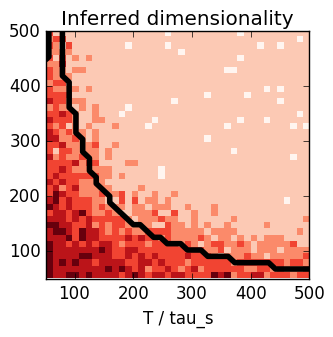

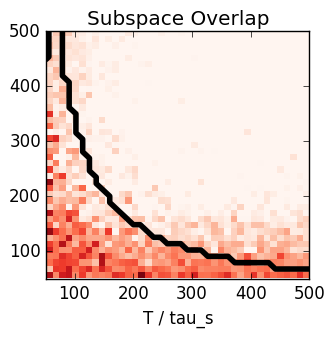

In [61]:
figure(figsize=(3.5, 3.5))
imshow(dims, aspect="auto", interpolation="nearest", origin="lower", cmap="Reds_r", extent=[minimum(Ts) / 𝛕s, maximum(Ts) / 𝛕s, minimum(Ms), maximum(Ms)]);
# colorbar();
contour(repmat(Ts' / 𝛕s, length(Ms), 1), repmat(Ms, 1, length(Ts)), theory, 1, linewidths=4, colors="k")
xlabel("T / tau_s");
title("Inferred dimensionality")
tight_layout()
savefig("../figures/dyn.dim.eps")

figure(figsize=(3.5, 3.5))
imshow(log10(err), aspect="auto", interpolation="nearest", origin="lower", cmap="Reds", vmax=0, vmin=-3, extent=[minimum(Ts) / 𝛕s, maximum(Ts) / 𝛕s, minimum(Ms), maximum(Ms)]);
# colorbar();
contour(repmat(Ts' / 𝛕s, length(Ms), 1), repmat(Ms, 1, length(Ts)), theory, 1, linewidths=4, colors="k")
xlabel("T / tau_s");
title("Subspace Overlap")
tight_layout()
savefig("../figures/dyn.err.eps")

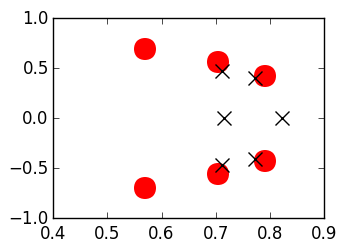

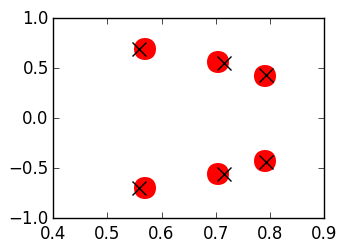

In [202]:
M1, T1 = 100, int(100 * 𝛕s)
M2, T2 = 300, int(300 * 𝛕s)

srand(932859)

figure(figsize=(3.5, 2.5))
model1 = DynModel(N, K, M1, T1, ϕs, ϕn)
X1 = sample(model1)
What1 = hoKalman(X1, 3, K)[1]
Ehat1, E1 = eig(What1)[1], eig(model1.sigW)[1]
plot(real(E1), imag(E1), "ro", markersize=16, markeredgewidth=0)
plot(real(Ehat1), imag(Ehat1), "kx", markeredgewidth=1, markersize=10)
xlim([0.4, 0.9]), ylim([-1, 1])
savefig("../figures/ssid.fail.eps")

figure(figsize=(3.5, 2.5))
model2 = DynModel(N, K, M2, T2, ϕs, ϕn)
model2.sigW = model1.sigW
X2 = sample(model2)
What2 = hoKalman(X2, 3, K)[1]
Ehat2, E2 = eig(What2)[1], eig(model2.sigW)[1]
plot(real(E2), imag(E1), "ro", markersize=16, markeredgewidth=0)
plot(real(Ehat2), imag(Ehat2), "kx", markeredgewidth=1, markersize=10)
xlim([0.4, 0.9]), ylim([-1, 1])
savefig("../figures/ssid.success.eps")

## Model Description
Data matrix is consisted of a $K$-dimensional slow and a $N$-dimensional fast (noise) part each with $T$ samples.

$$X = X_\text{slow} + X_\text{fast},$$

The two parts are generated from order one auto-regressive, AR(1), processes with coefficients $\phi_\text{slow}$ and $\phi_\text{fast}$. We further require that the slow and fast parts occupy different subspaces in the full $(N + K)$-dimensional space, or

$$X_\text{slow}^T X_\text{fast} = 0$$

## Question
We would like the understand the eigenvalue spetrum of the sample temporal correlation matrix in the regime where $N, T \to \infty, N / T \sim \mathcal{O}(1), K \ll N$,

$$C = \frac{1}{T}X^TX = \frac{1}{T}X_\text{slow}^T X_\text{slow} + \frac{1}{T}X_\text{fast}^T X_\text{fast}$$

To answer the following more specific questions:
 1. When is there a gap in the spectrum between the $K$-th and the $(K + 1)$th eigenvalues?
 2. When is there a statistically significant overlap between the $K$-th sample eigenvector and the subspace occupied by the slow part?
 3. What happens when we only access subsamples of $\hat{X} = UX$, where $U$ is a random sampling matrix?
 
## Challenge
Literature provides theoretical results to both questions when the eigenvectors of $X_\text{slow}^T X_\text{slow}$ are randomly oriented with respect to those of $X_\text{fast}^T X_\text{fast}$. But this is not the case in our model, since the time scales set by $\phi_\text{slow}$ and $\phi_\text{fast}$ implicitly relate the slow and fast parts.

We investigate, **numerically**, how our model deviates from existing theory.

### Function to sample our data model
It returns the embedding of the slow and fast parts, a sample of the data model, and a sample where the slow part is made uncorrelated with the fast part by random permutation of the columns of $X_\text{slow}$.

In [23]:
@everywhere function sample(N, T, K, ϕ_slow, ϕ_fast)
    # embedding matrix
#     U = qr(randn((N + K, N + K)))[1]
    U, _ = qr(randn((N, N)))
    V, _ = qr(randn((N, K)))
    
    # sample from the fast and slow AR1 models
    X_fast = rand(ARMPModel(N, T, ϕ_fast, 1.0))
    X_slow = rand(ARMPModel(K, T, ϕ_slow, 1.0))
    
#     println(size(U), size(V), size(X_fast), size(X_slow))
    
    # correlated and uncorrelated data
#     return U, U * [X_slow, X_fast], U * [X_slow[:, randperm(T)], X_fast]
    return U, V * X_slow + U * X_fast, V * X_slow[:, randperm(T)] + U * X_fast
end;

## Numerical analysis
### 1. Eigenvalue popping out: how does the $K$th eigenvalue of $X$ pop out differently with correlated vs. uncorrelated slow mode?
Vary $\phi_\text{slow}$ between $\left[\phi_\text{fast}, 1\right)$, how does the top eigenvalue of $C$ differ between the correlated and the uncorrelated cases?

**Interestingly, it seems that the correlated slow modes have only minor effect on the $K$th eigenvalue's phase transition**

In [27]:
@everywhere N, T, M, K, ϕ_fast = 2000, 5000, 200, 1, 0.1
# sample uniformly in variance instead of the autoregressive parameter
@everywhere var_slows = logspace(-log10(1 - ϕ_fast^2), -log10(1 - 0.95^2), 20)
@everywhere ϕ_slows = sqrt(1 - 1 ./ var_slows)

@everywhere function experiment(ϕ_slow)
    U, X, Xp = sample(N, T, K, ϕ_slow, ϕ_fast)
    
    ix = randperm(N)[1:M]
    X, Xp = X[ix, :], Xp[ix, :]
    
    ek, ek1 = eigs(X * X'; nev=K + 1)[1][[K, K + 1]]
    epk, epk1 = eigs(Xp * Xp'; nev=K + 1)[1][[K, K + 1]]
    return ek, ek1, epk, epk1
end

#### Collect the data

In [28]:
tmp = [@spawn experiment(ϕ_slow) for ϕ_slow in ϕ_slows];
tmp = map(fetch, tmp)

ek = map(x -> x[1], tmp);
ek1 = map(x -> x[2], tmp);
epk = map(x -> x[3], tmp);
epk1 = map(x -> x[4], tmp);

#### Plot an example phase transition

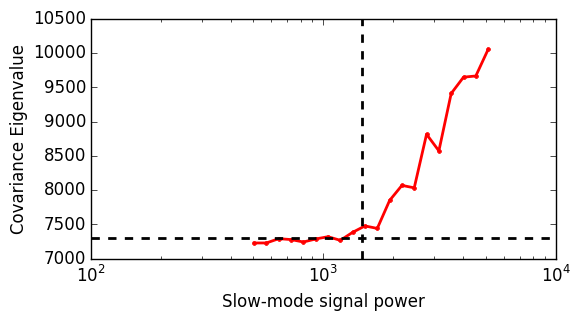

PyObject <matplotlib.text.Text object at 0x7f69a3d07310>

In [29]:
model = ARMPModel(M, T, ϕ_fast, 1)

l, u = ev_lb(model), ev_ub(model)
# b = sqrt(u)
thresh = ev_infloor(HDStat.ARMPCorrModel(model))

figure(figsize=(6, 3))
plot(var_slows * T * M / N, epk, "r.-", linewidth=2)
axvline(thresh, color="k", linestyle="--", linewidth=2)
axhline(u, color="k", linestyle="--", linewidth=2)
xscale("log"); xlabel("Slow-mode signal power"); ylabel("Covariance Eigenvalue")
# savefig("perturb.png")

#### Compare the correlated vs uncorrelated case

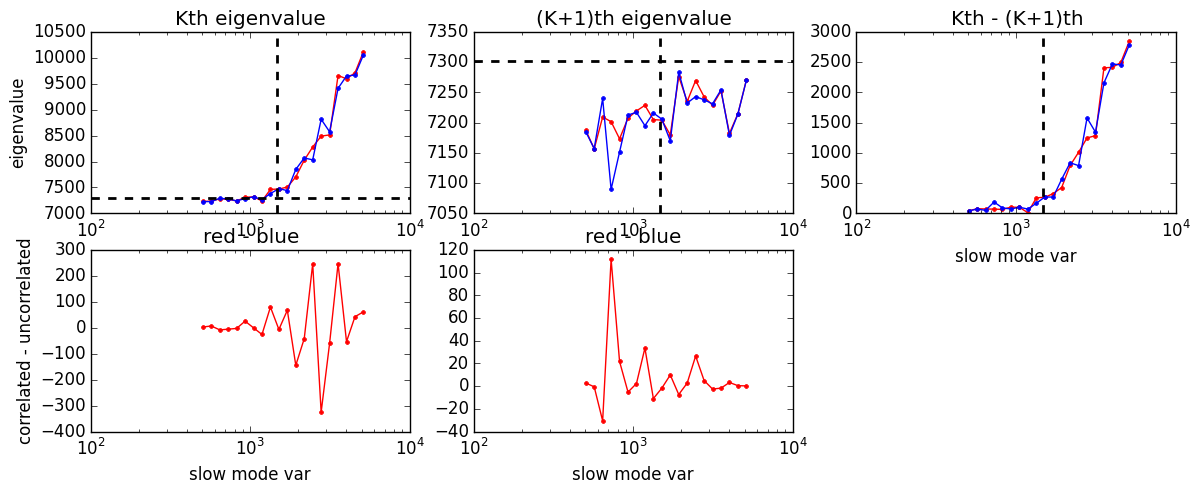

PyObject <matplotlib.text.Text object at 0x7f69a398e1d0>

In [30]:
figure(figsize=(14,5))
subplot(231)
plot(var_slows * T * M / N, ek, ".-", color="red")
plot(var_slows * T * M / N, epk, ".-", color="blue")
axvline(x=thresh, linewidth=2, color="k", linestyle="--")
axhline(y=u, linewidth=2, color="k", linestyle="--")
xscale("log"); title("Kth eigenvalue"); ylabel("eigenvalue")
subplot(232)
plot(var_slows * T * M / N, ek1, ".-", color="red")
plot(var_slows * T * M / N, epk1, ".-", color="blue")
axvline(x=thresh, linewidth=2, color="k", linestyle="--")
axhline(y=u, linewidth=2, color="k", linestyle="--")
xscale("log"); title("(K+1)th eigenvalue")
subplot(233)
plot(var_slows * T * M / N, ek - ek1, ".-", color="red")
plot(var_slows * T * M / N, epk - epk1, ".-", color="blue")
axvline(x=thresh, linewidth=2, color="k", linestyle="--")
xscale("log"); title("Kth - (K+1)th"); xlabel("slow mode var")
subplot(234)
plot(var_slows * T * M / N, ek - epk, ".-", color="red")
xscale("log"); title("red - blue"); xlabel("slow mode var"); ylabel("correlated - uncorrelated")
subplot(235)
plot(var_slows * T * M / N, ek1 - epk1, ".-", color="red")
xscale("log"); title("red - blue"); xlabel("slow mode var")

### 2. Subsampling and limited data: How does the correct recovery of the $K$-th eigenvector depend on the number of observed neurons and the length of observation? Does it differ much between correlated and uncorrelated slow modes?

To compute the projected norm with subsampling, we use the truncated the $K$-dimensional slow-model subspace,
$$\text{orth}(U[\text{randperm}(N + K, M), 1:K])$$
and apply the same one-sided $p$-value test with the null hypothesis,
$$\frac{\chi^2(K)}{M}.$$

We vary both $M$ and $T$ to look at the quality of recovery.

In [ ]:
@everywhere function inferK(model::ObsModel; Rs = None)
    if Rs == None; Rs = randfull(model)[:Rs]; end
    let noise = model.noise
        _, S, _ = svd(Rs)
        return sum(S .> noise.sigma * (sqrt(noise.p) + sqrt(model.m)))
    end
end

In [ ]:
@everywhere K, N, ϕs, ϕn = 20, 5000, 0.9, 0.1
@everywhere Ms, Ps = 40:10:500, 40:10:500

rst = [@spawn inferK(ObsModel(M, LowDModel(K, N, P, σs * sqrt(N / K)), MPModel(N, P, σn))) for M in Ms, P in Ps]
dims = map(fetch, rst);

theory = ((sqrt(1 / K - 1 / N) - sqrt(1 ./ Ms - 1 / N)).^2 .* sqrt(Ms)) * ((1 - sqrt(K ./ Ps')).^2 .* sqrt(Ps')) * σs^2 / σn^2 .> 1;

### 2.5. Eigenvectors: is there significant overlap between the $K$th eigenvector of sampled data and the $K$-dimensional slow-mode subspace?

We assume that all 1st through $K$th eigenvectors will have significant overlaps with the $K$-dimensional slow-mode subspace, as long as the $K$th eigenvector has a significant overlap with the slow-mode subspace.

We do this by computing the projected norm of the $K$-th eigenvector: $|v_K^T U_{1:K}|$, where $U_{1:K}$ is the $K$-dimensional slow-mode subspace. We compare this projected norm against the projected norm of a random $(N + K)$-dimensional unit vector (null hypothesis) to obtain a one-sided $p$-value.

We represent the null hypothesis using the approximate distribution
$$\frac{\chi^2(K)}{N + K},$$
which is exact in the limit $N \to \infty$.

We explore the $p$-values in a two dimensional parameter space spanned by $(\phi_\text{slow}, K) \in [\phi_\text{fast}, 1) \times \left\{1,\dots,N / 10\right\}$.

In [5]:
N, T, ϕ_fast = 500, 2000, 0.1
ϕ_slows = linspace(ϕ_fast, 0.9, 40)
Ks = linspace(1, N / 10, 40)

θ = zeros(length(ϕ_slows), length(Ks))
θp = zeros(length(ϕ_slows), length(Ks))
for (kslow, ϕ_slow) in enumerate(ϕ_slows)
    for (kK, K) in enumerate(Ks)
        U, X, Xp = sample(N, T, int(K), ϕ_slow, ϕ_fast)
        
        null_dist = Chisq(int(K))
        
        _, V = eigs(X * X' / T; nev=int(K))
        θ[kslow, kK] = ccdf(null_dist, norm(V[:, int(K)]' * U[:, 1:int(K)])^2 * int(N + K))
        
        _, V = eigs(Xp * Xp' / T; nev=int(K))
        θp[kslow, kK] = ccdf(null_dist, norm(V[:, int(K)]' * U[:, 1:int(K)])^2 * int(N + K))
    end
end

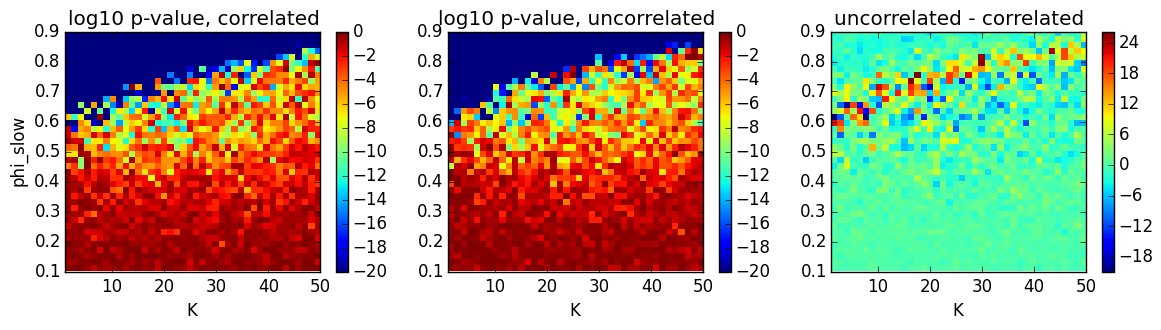

PyObject <matplotlib.text.Text object at 0x7f4ccaf4a750>

In [6]:
figure(figsize=(14, 3))
subplot(131)
imshow(log10(θ), interpolation="nearest", aspect="auto", origin="lower", extent=[minimum(Ks), maximum(Ks), minimum(ϕ_slows), maximum(ϕ_slows)], vmax=0, vmin=-20)
colorbar(); title("log10 p-value, correlated"); xlabel("K"); ylabel("phi_slow")
subplot(132)
imshow(log10(θp), interpolation="nearest", aspect="auto", origin="lower", extent=[minimum(Ks), maximum(Ks), minimum(ϕ_slows), maximum(ϕ_slows)], vmax=0, vmin=-20)
colorbar(); title("log10 p-value, uncorrelated"); xlabel("K")
subplot(133)
imshow(log10(θp ./ θ), interpolation="nearest", aspect="auto", origin="lower", extent=[minimum(Ks), maximum(Ks), minimum(ϕ_slows), maximum(ϕ_slows)])
colorbar(); title("uncorrelated - correlated"); xlabel("K")

### 3. Subsampling and limited data: How does the correct recovery of the $K$-th eigenvector depend on the number of observed neurons and the length of observation? Does it differ much between correlated and uncorrelated slow modes?

To compute the projected norm with subsampling, we use the truncated the $K$-dimensional slow-model subspace,
$$\text{orth}(U[\text{randperm}(N + K, M), 1:K])$$
and apply the same one-sided $p$-value test with the null hypothesis,
$$\frac{\chi^2(K)}{M}.$$

We vary both $M$ and $T$ to look at the quality of recovery.

In [7]:
N, K, ϕ_fast, ϕ_slow = 500, 5, 0.1, 0.9
Ts = linspace(400, 1000, 40)
Ms = linspace(10, 300, 40)

θmt = zeros(length(Ms), length(Ts))
θmtp = zeros(length(Ms), length(Ts))
for (kM, M) in enumerate(Ms)
    for (kT, T) in enumerate(Ts)
        U, X, Xp = sample(N, int(T), K, ϕ_slow, ϕ_fast)
        ix = randperm(N + K)[1:int(M)]
        
        Um, Xm, Xpm = U[ix, :], X[ix, :], Xp[ix, :]
        Um, _ = qr(Um)
        
        null_dist = Chisq(int(K))
        
        _, V = eigs(Xm * Xm' / T; nev=K)
        θmt[kM, kT] = ccdf(null_dist, norm(V[:, K]' * Um[:, 1:K])^2 * M)
        
        _, V = eigs(Xpm * Xpm' / T; nev=K)
        θmtp[kM, kT] = ccdf(null_dist, norm(V[:, K]' * Um[:, 1:K])^2 * M)
    end
end

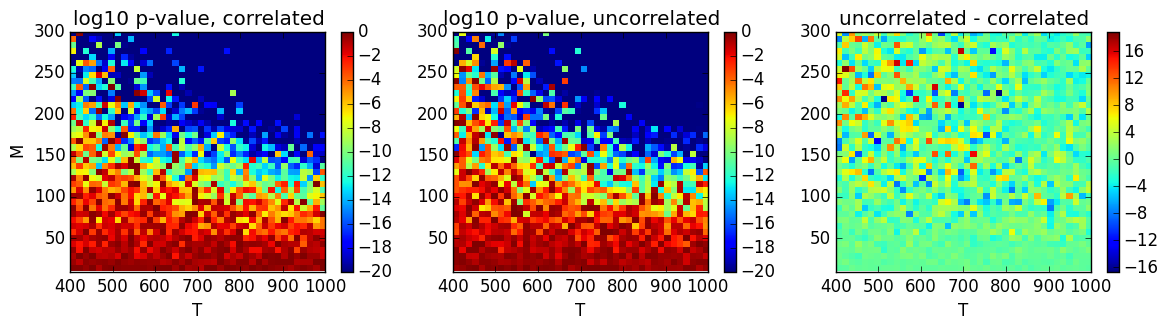

In [8]:
figure(figsize=(14, 3))
subplot(131)
imshow(log10(θmt), aspect="auto", origin="lower", interpolation="nearest", extent=[minimum(Ts), maximum(Ts), minimum(Ms), maximum(Ms)], vmin=-20); colorbar(); title("log10 p-value, correlated"); xlabel("T"); ylabel("M")
subplot(132)
imshow(log10(θmtp), aspect="auto", origin="lower", interpolation="nearest", extent=[minimum(Ts), maximum(Ts), minimum(Ms), maximum(Ms)], vmin=-20); colorbar(); title("log10 p-value, uncorrelated"); xlabel("T");
subplot(133)
imshow(log10(θmtp) - log10(θmt), aspect="auto", origin="lower", interpolation="nearest", extent=[minimum(Ts), maximum(Ts), minimum(Ms), maximum(Ms)]); colorbar(); title("uncorrelated - correlated"); xlabel("T");

### 4. Predicting the threshold signal power to infer the $K$-th eigenvector of the signal correctly

In [ ]:
# using PyPlot

# addprocs(12)
# @everywhere require("HDStat.jl")
# @everywhere using HDStat, Distributions

@everywhere N, K, ϕ_fast, ϕ_slow = 1996, 4, 0.1, 0.9

@everywhere Ts = linspace(500, 5000, 200)
@everywhere Ms = linspace(10, 450, 200)

@everywhere function corrThresh(model)
    l, u = lb(model)^2, ub(model)^2
    mu = t -> spec(model)(sqrt(t)) / 2 / sqrt(t)
    return sqrt(pertThresh(mu, l, u, 1.0))
end

thresh = [@spawn corrThresh(ARMPModel(int(M), int(T), ϕ_fast)) for M = Ms, T = Ts]
thresh = map(fetch, thresh)
# thresh = convert(Array{Float64, 2}, thresh)

In [ ]:
@everywhere function inferK(N, K, M, T, ϕ_fast, ϕ_slow)
    _, x, _ = sample(N, T, K, ϕ_slow, ϕ_fast)
    x = x[randperm(N + K)[1:M], :]
    
    thresh = ub(ARMPModel(M, T, ϕ_fast))
    return sum(eig(x * x' / T)[1] .> thresh)
end

inferredK = [@spawn inferK(N, K, int(M), int(T), ϕ_fast, ϕ_slow) for M = Ms, T = Ts]
inferredK = map(fetch, inferredK)

In [ ]:
mask = thresh .< repmat(Ms, 1, length(Ts)) ./ N / (1 - ϕ_slow^2)

figure(figsize=(7, 5))
imshow(inferredK, cmap="RdBu", interpolation="nearest", origin="lower", aspect="auto", extent=[minimum(Ts), maximum(Ts), minimum(Ms), maximum(Ms)])
colorbar()
contour(Ts, Ms, mask, 1, colors="k", linewidths=4)
xlabel("T"); ylabel("M")